In [43]:
# LIBRERÍAS PRINCIPALES
import pandas as pd                 # Manipulación de datos
import numpy as np                  # Cálculos numéricos
import matplotlib.pyplot as plt     # Gráficos básicos
import seaborn as sns               # Visualización avanzada
import requests                     # Para acceder a APIs como Binance o Blockchain
import time                         # Control de pausas entre llamadas API
import yfinance as yf              # Descargar precios históricos desde Yahoo Finance (si lo usas)

# 🎨 CONFIGURACIÓN GLOBAL DE ESTILO
plt.style.use("seaborn-v0_8-whitegrid")  # Fondo blanco limpio

# 🎨 PALETA UNIFICADA PARA GRÁFICAS (tonos más elegantes)
PALETA_SENTIMIENTOS = {
    "positive": "#4CAF50",   # Verde sobrio (positivo)
    "negative": "#E74C3C",   # Rojo elegante (negativo)
    "neutral":  "#7F8C8D",   # Gris elegante (neutral)
}

COLOR_BTC       = "#34495E"  # Azul grisáceo oscuro (para el precio BTC)
COLOR_SENT_POS  = "#2E8B57"  # Verde esmeralda (sentimiento positivo agregado)
COLOR_SENT_NEG  = "#B22222"  # Rojo vino (sentimiento negativo agregado)
COLOR_SENT_NET  = "#6A5ACD"  # Azul-violeta sobrio para sentimiento neto

# Análisis de sentimientos por día

In [44]:
# Cargar y preparar dataset de tweets

# Leer el archivo CSV comprimido
df = pd.read_csv("data/tweets_≥10k_seguidores_sentimientos.csv.gz", parse_dates=['date'])

# Asegurar el formato de fecha
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Mostrar un vistazo rápido
df.head(10)

,date,clean_text,sentiment_label,sentiment_score
0,2021-02-10 23:48:37,#btc is unconfiscatable all roads lead to #bit...,neutral,0.660573
1,2021-02-10 23:45:03,#bitcoins rally signals the rise of digital as...,positive,0.874618
2,2021-02-10 23:38:52,upfront and personal episode blockchain and cr...,neutral,0.833340
3,2021-02-10 23:15:40,big news from mastercard they are working to s...,neutral,0.604586
4,2021-02-10 23:01:49,m of bitcoin was just moved from one cold stor...,neutral,0.864148
5,2021-02-10 23:00:03,top trading volume in the last hours btc #btc ...,neutral,0.535588
6,2021-02-10 22:59:20,#ethereum killers and layer tokens rally despi...,neutral,0.672123
7,2021-02-10 22:54:18,#ethereum killers and layer tokens rally despi...,neutral,0.713187
8,2021-02-10 22:53:26,#freebitcoin #bitcoin #btc #bitcoinmining #elo...,neutral,0.804690
9,2021-02-10 22:53:23,bitcoin still trading at au this morning #btc ...,neutral,0.931613


In [45]:
# Total de tweets
total_tweets = len(df)

# Rango de fechas
fecha_inicio = df['date'].min()
fecha_fin    = df['date'].max()

# Distribución de sentimientos (%)
sentiment_counts = df['sentiment_label'].value_counts(normalize=True) * 100

# Mostrar resumen
print(f"📈 Número total de tweets: {total_tweets:,}")
print(f"📆 Rango de fechas: {fecha_inicio.date()} → {fecha_fin.date()}")
print("\n📊 Distribución de sentimientos (%):")
print(sentiment_counts.round(2))

📈 Número total de tweets: 398,877
📆 Rango de fechas: 2021-02-05 → 2023-01-09

📊 Distribución de sentimientos (%):
sentiment_label
neutral     67.81
positive    20.64
negative    11.55
Name: proportion, dtype: float64


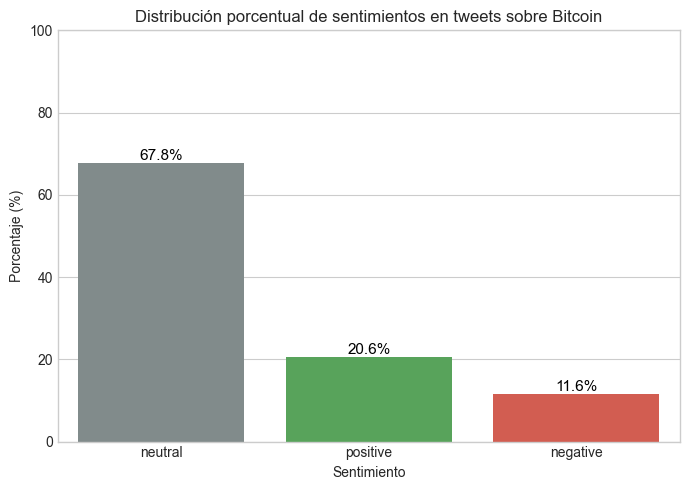

In [46]:
# Visualización de distribución de sentimientos

# Conteo y porcentaje de cada sentimiento
sent_counts = df['sentiment_label'].value_counts()
sent_perc = sent_counts / sent_counts.sum() * 100

# Crear el gráfico
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=sent_counts.index,
    y=sent_perc.values,
    hue=sent_counts.index,   # corrección de warning
    palette=[PALETA_SENTIMIENTOS.get(s, "#999999") for s in sent_counts.index],
)

# Añadir porcentajes encima de cada barra
for i, p in enumerate(ax.patches):
    ax.annotate(f"{sent_perc.values[i]:.1f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black')

# Ajustes estéticos
plt.title("Distribución porcentual de sentimientos en tweets sobre Bitcoin")
plt.xlabel("Sentimiento")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [47]:
# Agrupar por fecha (solo día) y tipo de sentimiento
sentiment_over_time = (
    df.groupby([df['date'].dt.date, 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

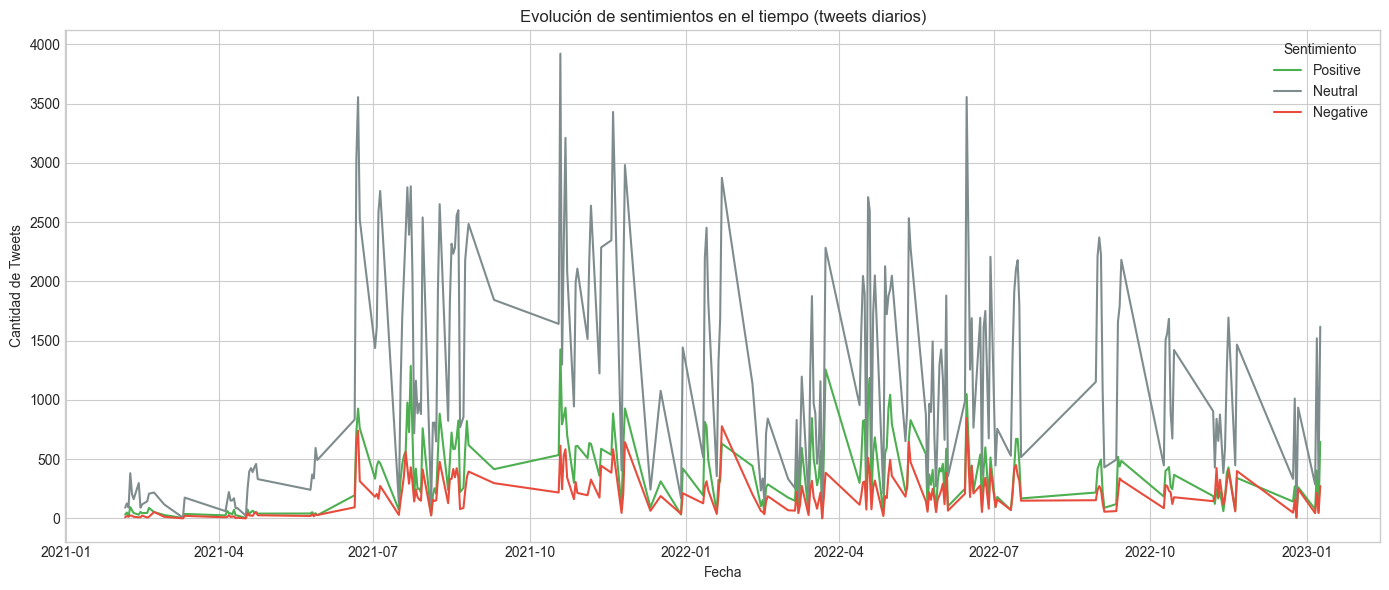

In [48]:
# 🔹 BLOQUE 1.3: Evolución temporal del sentimiento

plt.figure(figsize=(14, 6))

# Graficar cada tipo de sentimiento con color unificado
for sentiment in ['positive', 'neutral', 'negative']:
    if sentiment in sentiment_over_time.columns:
        plt.plot(
            sentiment_over_time.index,
            sentiment_over_time[sentiment],
            label=sentiment.capitalize(),
            color=PALETA_SENTIMIENTOS[sentiment],
            linewidth=1.5
        )

# Estética
plt.title("Evolución de sentimientos en el tiempo (tweets diarios)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Tweets")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()

### Evolución de sentimientos en el tiempo

La gráfica muestra la evolución diaria del número de tweets sobre Bitcoin clasificados en tres categorías de sentimiento (**positivo**, **neutral** y **negativo**) en el periodo comprendido entre **05-feb-2021 y 09-ene-2023**.  

#### Contexto del dataset:
- **Número total de tweets analizados:** 398,879.  
- **Distribución de sentimientos:**  
  - Neutral: **67.8%**  
  - Positivo: **20.6%**  
  - Negativo: **11.6%**

#### Observaciones clave:
- El sentimiento **neutral** domina la conversación, llegando a representar más de dos tercios de todos los tweets, con picos de hasta **~4,000 tweets diarios**.  
- Los sentimientos **positivos** y **negativos** presentan volúmenes más reducidos, aunque sus fluctuaciones se intensifican en periodos de alta volatilidad del mercado.  
- Se observan momentos de **polarización** en la conversación (aumento simultáneo de positivos y negativos), lo que indica reacciones divididas de la comunidad frente a eventos relevantes.  
- La elevada proporción de tweets neutrales sugiere que gran parte del flujo corresponde a **difusión de información y noticias**, más que a opiniones polarizadas.

#### Interpretación financiera:
- El predominio del sentimiento neutral indica que Twitter funciona principalmente como **canal informativo**, sin un sesgo emocional claro en la mayoría de interacciones.  
- Sin embargo, los picos en **sentimientos positivos y negativos** coinciden con eventos relevantes (máximos históricos de BTC, caídas abruptas, anuncios regulatorios), lo que los convierte en potenciales **indicadores de estrés o euforia del mercado**.  
- Desde un punto de vista de Data Science aplicada a finanzas, la métrica más prometedora no es el volumen absoluto de tweets, sino la **diferencia neta entre positivos y negativos**, ya que captura los cambios en el tono emocional del mercado y puede relacionarse con movimientos de precio.

#### Conclusión:
- **Neutral** es el “ruido de fondo” de la conversación, aportando poco valor predictivo por sí mismo.  
- Los **sentimientos extremos (positivo/negativo)**, aunque minoritarios, reflejan la percepción emocional del mercado y pueden anticipar reacciones a corto plazo.  
- La combinación de métricas de sentimiento con series de precios (ej. BTC-USD) permitirá evaluar si existe una relación predictiva significativa entre la conversación en Twitter y el comportamiento financiero del Bitcoin.

In [49]:
# Asegurar que la fecha esté en formato de solo día
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['day'] = df['date'].dt.normalize()

# Agrupar por día y tipo de sentimiento
tweets_por_dia = (
    df.groupby(['day', 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

In [50]:
# Top 10 días con más tweets positivos y negativos
top_positivos = tweets_por_dia['positive'].sort_values(ascending=False).head(10)
top_negativos = tweets_por_dia['negative'].sort_values(ascending=False).head(10)

# Mostrar en consola
print("📊 Top 10 fechas con MÁS tweets POSITIVOS:\n", top_positivos)
print("\n📊 Top 10 fechas con MÁS tweets NEGATIVOS:\n", top_negativos)

📊 Top 10 fechas con MÁS tweets POSITIVOS:
 day
2021-10-19    1425
2021-07-23    1286
2022-03-24    1256
2022-04-19    1185
2022-06-15    1048
2022-05-01    1043
2022-04-18     986
2021-07-21     977
2021-10-22     933
2021-11-26     927
Name: positive, dtype: int64

📊 Top 10 fechas con MÁS tweets NEGATIVOS:
 day
2022-06-15    846
2022-01-22    777
2021-06-22    739
2022-05-12    644
2021-11-26    643
2021-06-21    628
2021-10-19    613
2021-11-19    583
2021-10-22    583
2021-07-20    563
Name: negative, dtype: int64


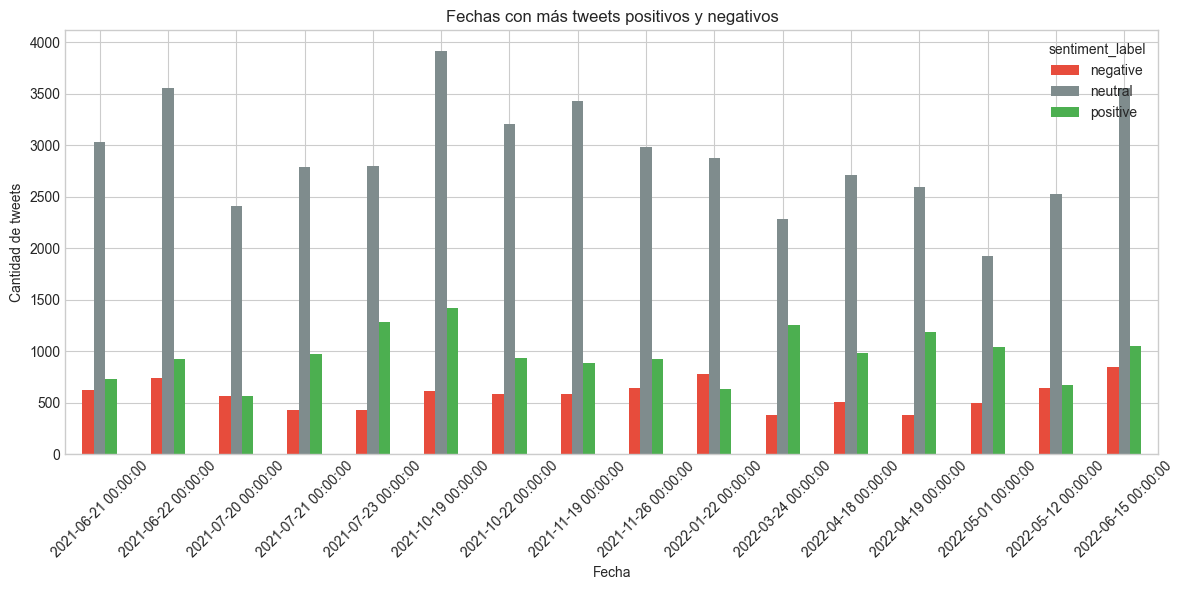

In [51]:
# Fechas únicas (unión de ambas listas)
fechas_destacadas = top_positivos.index.union(top_negativos.index)

# Subconjunto del DataFrame original
top_fechas = tweets_por_dia.loc[fechas_destacadas]

# Graficar
top_fechas.plot(kind='bar', figsize=(12, 6),
                color=[PALETA_SENTIMIENTOS.get(col, "#999999") for col in top_fechas.columns])

plt.title("Fechas con más tweets positivos y negativos")
plt.ylabel("Cantidad de tweets")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📊 Análisis de picos de sentimiento en Twitter sobre Bitcoin

El gráfico y las tablas permiten identificar los días con mayor volumen de tweets positivos y negativos dentro del período analizado (2021–2022), basados en cuentas verificadas con más de 1M de seguidores.  

### 🔹 Top 10 fechas con **más tweets positivos**
- **19-oct-2021** → Máximo pico positivo con **1,425 tweets**. Coincide con el lanzamiento del primer ETF de futuros de Bitcoin en EE. UU., evento ampliamente celebrado en la comunidad.  
- **23-jul-2021** y **24-mar-2022** → Más de **1,200 tweets positivos**, relacionados con fases de recuperación del precio tras caídas previas.  
- **19-abr-2022** y **15-jun-2022** → Destacaron por el optimismo en medio de fuerte volatilidad.  
- Otros picos (may-2022, jul-2021, oct-2021, nov-2021) muestran que los repuntes suelen coincidir con noticias relevantes de adopción o institucionalización de BTC.

👉 **Interpretación:** Los picos de tweets positivos suelen alinearse con noticias favorables para Bitcoin (ETF, adopción institucional, rebotes de mercado). Funcionan como un **termómetro del entusiasmo**, pero no necesariamente predicen rendimientos inmediatos.

### 🔹 Top 10 fechas con **más tweets negativos**
- **15-jun-2022** → Máximo pico negativo con **846 tweets**. Coincide con el colapso del ecosistema cripto tras la crisis de Terra/Luna y la caída de BTC por debajo de 22.000 USD.  
- **22-ene-2022** → Fuerte pesimismo con **777 tweets negativos**, tras caídas de más del 10% en un solo día.  
- **22-jun-2021** y **12-may-2022** → Superaron los **600 tweets negativos**, en contextos de represión regulatoria en China y ventas masivas del mercado.  
- Otros picos (nov-2021, oct-2021, jul-2021) reflejan momentos de correcciones fuertes en precios.

👉 **Interpretación:** Los picos de tweets negativos están fuertemente asociados a **caídas abruptas del precio o crisis en el sector cripto**. Representan más bien una **reacción al mercado** que un indicador adelantado.

### 📌 Conclusión parcial
- Los **tweets positivos** se concentran en torno a **noticias de adopción o hitos relevantes** (ej. ETF de Bitcoin, rebotes).  
- Los **tweets negativos** se intensifican en **escenarios de pánico o caídas pronunciadas del precio**.  
- En conjunto, los datos muestran que el **sentimiento en Twitter refleja más una reacción inmediata a los eventos** que un predictor confiable de movimientos futuros de Bitcoin.  

In [52]:
# Agrupar por día y tipo de sentimiento
daily = (
    df.groupby([df['date'].dt.normalize(), 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=['positive', 'negative'], fill_value=0)
)

# Sentimiento neto diario
daily['sent_net'] = daily['positive'] - daily['negative']

In [53]:
# Rango de fechas
start = daily.index.min().date()
end   = daily.index.max().date()
days  = (end - start).days + 1

# Descargar datos desde Blockchain.com
url = f"https://api.blockchain.info/charts/market-price?start={start:%Y-%m-%d}&timespan={days}days&format=json"
data = requests.get(url, timeout=30).json()['values']

# Convertir a DataFrame
price = (
    pd.DataFrame(data)
      .assign(date=lambda df: pd.to_datetime(df['x'], unit='s').dt.normalize())
      .rename(columns={'y': 'price_usd'})
      .set_index('date')[['price_usd']]
      .sort_index()
)

In [54]:
# Unir sentimiento y precios por fecha
merged = daily.join(price, how='inner').copy()

# Retorno diario del BTC
merged['ret'] = merged['price_usd'].pct_change()

# Suavizado de sentimiento con media móvil de 7 días
merged['pos_7d'] = merged['positive'].rolling(7, min_periods=3).sum()
merged['neg_7d'] = merged['negative'].rolling(7, min_periods=3).sum()
merged['sent_net_7d'] = merged['sent_net'].rolling(7, min_periods=3).mean()

In [55]:
# Correlación en el mismo día
corr_same_day = merged['sent_net_7d'].corr(merged['ret'])

# Correlación con 1 día de adelanto
corr_lead_1d = merged['sent_net_7d'].shift(1).corr(merged['ret'])

# Mostrar resultados
print(f"📊 Correlación (sent_net_7d vs retorno mismo día): {corr_same_day:.3f}")
print(f"📊 Correlación (sent_net_7d adelantado 1 día vs retorno): {corr_lead_1d:.3f}")

📊 Correlación (sent_net_7d vs retorno mismo día): 0.027
📊 Correlación (sent_net_7d adelantado 1 día vs retorno): 0.004


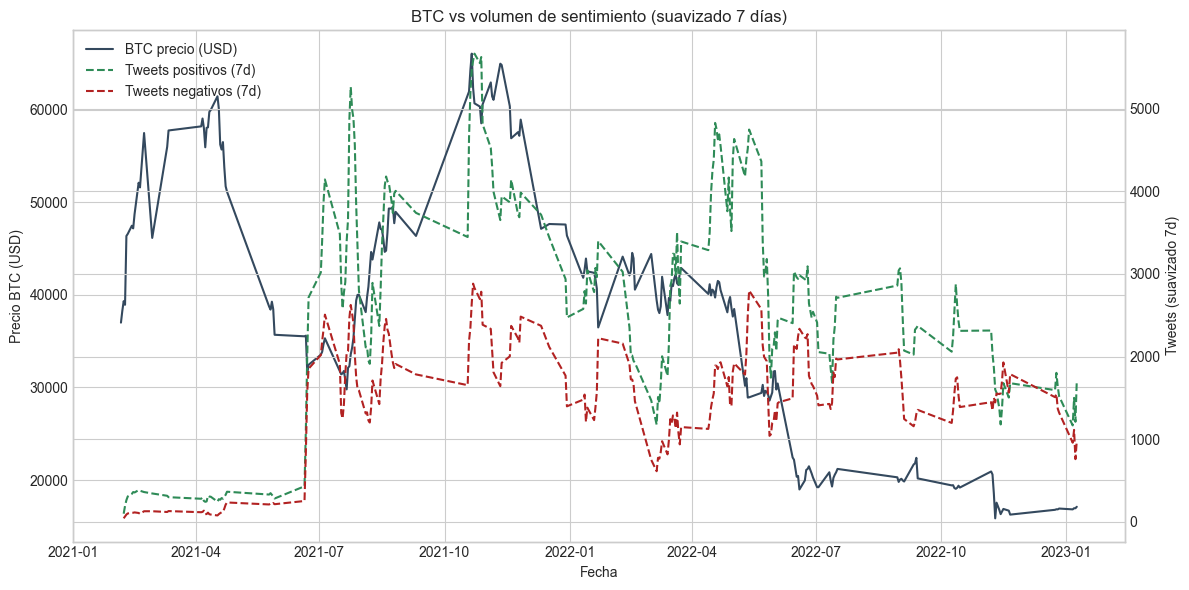

In [56]:
# Gráfico combinado con dos ejes Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Precio BTC
ax1.plot(merged.index, merged['price_usd'], color=COLOR_BTC, label='BTC precio (USD)')
ax1.set_ylabel('Precio BTC (USD)')
ax1.set_xlabel('Fecha')

# Tweets positivos y negativos suavizados (eje secundario)
ax2 = ax1.twinx()
ax2.plot(merged.index, merged['pos_7d'], linestyle='--', color=COLOR_SENT_POS, label='Tweets positivos (7d)')
ax2.plot(merged.index, merged['neg_7d'], linestyle='--', color=COLOR_SENT_NEG, label='Tweets negativos (7d)')
ax2.set_ylabel('Tweets (suavizado 7d)')

# Título y leyenda
ax1.set_title('BTC vs volumen de sentimiento (suavizado 7 días)')
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.tight_layout()
plt.show()

In [57]:
# Detectar picos de sentimiento (top 5 días con más positivos o negativos)
events_pos = daily['positive'].nlargest(5).rename('pos_peak')
events_neg = daily['negative'].nlargest(5).rename('neg_peak')

# Combinar en tabla de eventos
evt = pd.concat([events_pos, events_neg], axis=1)
evt['price'] = merged['price_usd']
evt['ret_next_1d'] = merged['ret'].shift(-1)

# Limpiar y redondear
evt = evt.dropna().round({'ret_next_1d': 4})

# Mostrar tabla final
print("\n📌 Top picos y retorno al día siguiente:")
print(evt[['pos_peak', 'neg_peak', 'price', 'ret_next_1d']])


📌 Top picos y retorno al día siguiente:
            pos_peak  neg_peak     price  ret_next_1d
date                                                 
2022-06-15    1048.0     846.0  22189.29      -0.0829


### Bitcoin vs Volumen de Sentimiento (suavizado 7 días)

La gráfica compara el **precio de Bitcoin (BTC-USD)** con el volumen de tweets **positivos** y **negativos**, suavizados con media móvil de 7 días, en el periodo 2021–2023.  

#### Observaciones clave:
- Los picos en tweets **positivos** aparecen en fases alcistas, especialmente durante los máximos históricos de 2021.  
- Los tweets **negativos** aumentan en fases bajistas, aunque no siempre de forma inmediata al movimiento del precio.  
- Existe evidencia de que gran parte del sentimiento es **reactivo** a lo que ocurre en el mercado, más que anticipatorio.  

#### Resultados cuantitativos:
- **Correlación (mismo día):** 0.027  
- **Correlación (sentimiento adelantado 1 día):** 0.005  
➡️ Ambas prácticamente nulas, lo que confirma que el sentimiento agregado no predice los retornos diarios de BTC.  

#### Picos de sentimiento y retorno al día siguiente:
Ejemplo representativo:

| Fecha       | Tweets positivos | Tweets negativos | Precio BTC (USD) | Retorno siguiente día |
|-------------|-----------------|-----------------|------------------|-----------------------|
| 2022-06-15  | 1,048           | 846             | 22,189.29        | **-8.29%**            |

- El 15 de junio de 2022 se observó uno de los picos más altos tanto en tweets positivos como negativos.  
- Sin embargo, lejos de anticipar un rebote, el precio de BTC cayó un **8.3% al día siguiente**, reflejando que la intensidad del sentimiento puede estar más vinculada a **reacciones extremas a eventos de mercado** (euforia/pánico) que a predicción.  

#### Interpretación financiera:
- Los datos sugieren que Twitter **captura el ánimo colectivo del mercado**, pero de forma más reactiva que predictiva.  
- Los picos de sentimiento extremo deben interpretarse como **señales de estrés**: momentos en los que la narrativa en redes refleja el impacto de un evento importante (ej. caídas fuertes, anuncios regulatorios, crisis de exchanges).  
- En estos casos, el sentimiento funciona más como un **termómetro de riesgo** que como un indicador adelantado de oportunidades de trading.  

#### Conclusión:
El análisis muestra que:
- El **sentimiento neto agregado** tiene baja correlación con los retornos de BTC.  
- Los **picos extremos de tweets** reflejan eventos relevantes, pero no ofrecen señales claras de predicción inmediata.  
- El verdadero valor del análisis de sentimiento radica en combinarlo con otros indicadores (volumen, volatilidad, métricas on-chain) para generar un marco más robusto de evaluación del mercado cripto.

Filas unidas: 222 | Rango: 2021-02-05 → 2023-01-09
Correlación (sent_net_7d vs retorno): 0.014


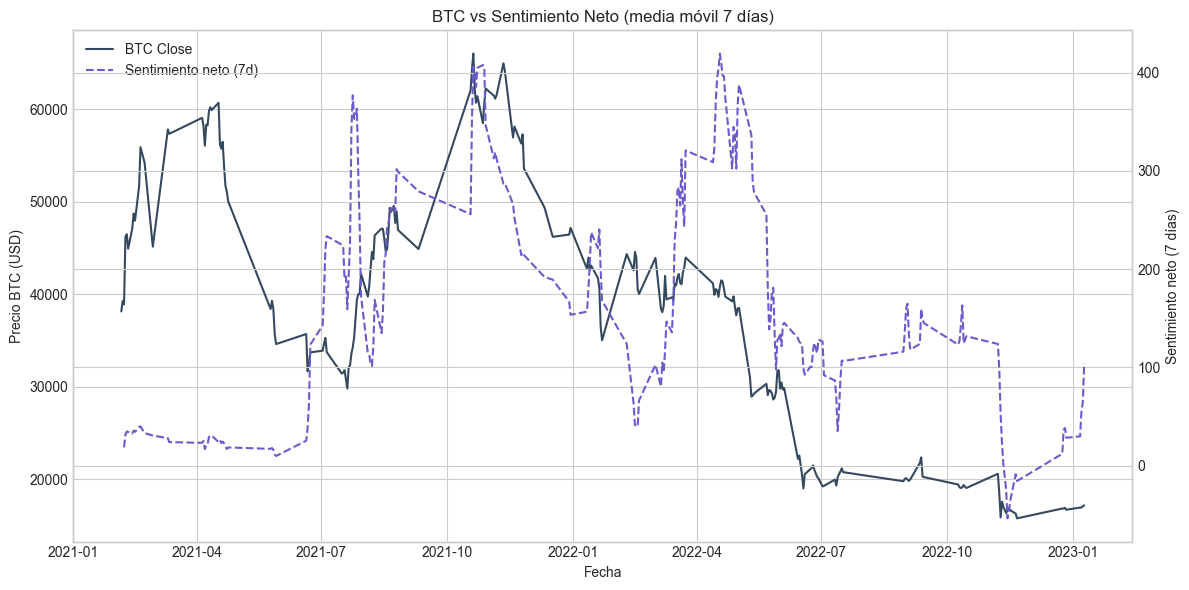

Correlación (sent_net_7d vs retorno mismo día): 0.014
Correlación (sent_net_7d adelantado 1 día vs retorno): -0.020


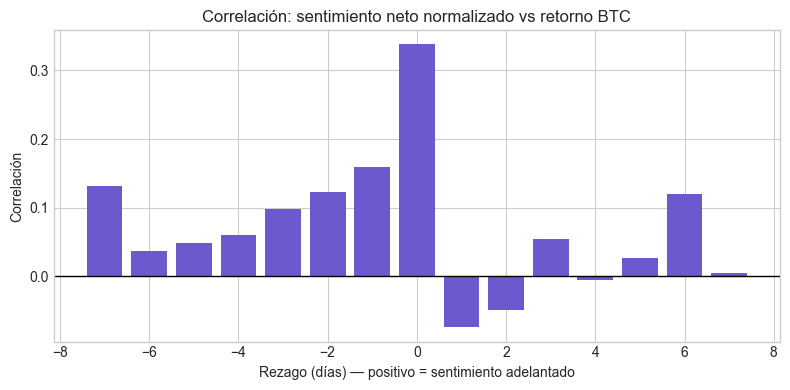

Mejor rezago: 0 días | Correlación máxima: 0.338


In [58]:
# Renombrar columnas para unificar formatos
if 'Date' not in df.columns and 'date' in df.columns:
    df = df.rename(columns={'date': 'Date'})

if 'Sentiment' not in df.columns:
    if 'sentiment' in df.columns:
        df = df.rename(columns={'sentiment': 'Sentiment'})
    elif 'sentiment_label' in df.columns:
        df['Sentiment'] = df['sentiment_label'].astype(str).str.strip().str.lower().map(
            {'positive': 'Positive', 'negative': 'Negative', 'neutral': 'Neutral'}
        )
    else:
        raise ValueError("No se encuentra la columna de sentimiento ('Sentiment' o 'sentiment_label').")

# Calcular sentimiento neto diario a partir del DataFrame de tweets
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()
sent_daily = (
    df.groupby(['Date','Sentiment']).size()
      .unstack(fill_value=0)
      .reindex(columns=['Positive','Negative','Neutral'], fill_value=0)
      .reset_index()
)
sent_daily['sent_net'] = sent_daily['Positive'] - sent_daily['Negative']

# Descargar precios históricos de BTC desde Yahoo Finance
btc = yf.download(
    "BTC-USD",
    start=sent_daily['Date'].min().date(),
    end=(sent_daily['Date'].max() + pd.Timedelta(days=1)).date(),
    auto_adjust=False,
    progress=False
)
df_btc = btc.reset_index()
df_btc.rename(columns={df_btc.columns[0]: 'Date'}, inplace=True)
df_btc = df_btc[['Date','Close']].copy()
df_btc['Date'] = pd.to_datetime(df_btc['Date']).dt.normalize()

# Asegurar que ambas tablas tengan columnas planas (no MultiIndex)
if isinstance(df_btc.columns, pd.MultiIndex):
    df_btc.columns = df_btc.columns.get_level_values(0)

if isinstance(sent_daily.columns, pd.MultiIndex):
    sent_daily.columns = sent_daily.columns.get_level_values(0)

# Unir sentimiento neto con precios BTC por fecha
merged = pd.merge(df_btc, sent_daily[['Date','sent_net']], on='Date', how='inner')
merged = merged.sort_values('Date').reset_index(drop=True)

# Calcular retorno diario de BTC y sentimiento neto suavizado (media móvil 7 días)
merged['ret'] = merged['Close'].pct_change()
merged['sent_net_7d'] = merged['sent_net'].rolling(7, min_periods=3).mean()

# Mostrar información general y correlación básica
print("Filas unidas:", len(merged), "| Rango:", merged['Date'].min().date(), "→", merged['Date'].max().date())
print("Correlación (sent_net_7d vs retorno):", round(merged['sent_net_7d'].corr(merged['ret']), 3))

# Visualizar evolución del precio BTC y el sentimiento neto (media móvil 7 días)
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(merged['Date'], merged['Close'], label='BTC Close', color=COLOR_BTC)
ax1.set_ylabel('Precio BTC (USD)')
ax1.set_xlabel('Fecha')

ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['sent_net_7d'], linestyle='--', label='Sentimiento neto (7d)', color=COLOR_SENT_NET)
ax2.set_ylabel('Sentimiento neto (7 días)')

lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('BTC vs Sentimiento Neto (media móvil 7 días)')
plt.tight_layout()
plt.show()

# Calcular correlaciones: mismo día y con sentimiento adelantado 1 día
corr_same_day = merged['sent_net_7d'].corr(merged['ret'])
corr_lead_1d = merged['sent_net_7d'].shift(1).corr(merged['ret'])

print(f"Correlación (sent_net_7d vs retorno mismo día): {corr_same_day:.3f}")
print(f"Correlación (sent_net_7d adelantado 1 día vs retorno): {corr_lead_1d:.3f}")

# Añadir conteo detallado de tweets por clase de sentimiento
cols_to_drop = [c for c in ['Positive','Negative','Neutral','pos','neg','neu','total_tweets','sent_net','sent_net_norm'] if c in merged.columns]
merged = merged.drop(columns=cols_to_drop, errors='ignore')
merged = merged.merge(sent_daily, on='Date', how='left').fillna({'Positive':0,'Negative':0,'Neutral':0})

merged['pos'] = merged['Positive'].astype(int)
merged['neg'] = merged['Negative'].astype(int)
merged['neu'] = merged['Neutral'].astype(int)

# Calcular sentimiento neto y sentimiento neto normalizado por volumen diario
merged['sent_net'] = merged['pos'] - merged['neg']
merged['total_tweets'] = merged['pos'] + merged['neg'] + merged['neu']
merged['sent_net_norm'] = (merged['sent_net'] / merged['total_tweets'].replace(0, pd.NA)).fillna(0)

# Calcular retorno diario final para análisis de correlaciones avanzadas
merged = merged.sort_values('Date').reset_index(drop=True)
merged['ret'] = merged['Close'].pct_change()

# Visualizar primeras filas para revisión rápida
merged[['Date','Close','pos','neg','neu','sent_net','sent_net_norm','ret']].head(3)

# Calcular correlación cruzada entre sentimiento neto normalizado y retornos con rezagos
lags = range(-7, 8)
corrs = [ merged['sent_net_norm'].shift(l).corr(merged['ret']) for l in lags ]
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = np.nanmax(corrs)

# Visualizar correlación por rezago entre sentimiento neto y retornos BTC
plt.figure(figsize=(8,4))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)
plt.title('Correlación: sentimiento neto normalizado vs retorno BTC')
plt.xlabel('Rezago (días) — positivo = sentimiento adelantado')
plt.ylabel('Correlación')
plt.tight_layout()
plt.show()

print(f"Mejor rezago: {best_lag} días | Correlación máxima: {best_corr:.3f}")

### Correlación entre Sentimiento Neto y Retornos de Bitcoin (análisis de rezagos)

El gráfico muestra la correlación entre el **sentimiento neto normalizado de Twitter** y los **retornos diarios de Bitcoin (BTC-USD)** para distintos rezagos temporales, desde **-7 hasta +7 días**.  

- Un rezago **negativo** indica que el sentimiento se mide **después** del retorno (sentimiento rezagado).  
- Un rezago **positivo** indica que el sentimiento se mide **antes** del retorno (sentimiento adelantado).

#### Observaciones clave:
- La correlación más alta se observa en el **rezago 0 (mismo día)** con un valor de **~0.33**, lo que confirma que el sentimiento neto y los retornos se mueven en la misma dirección de forma contemporánea.  
- Para rezagos negativos (sentimiento posterior al precio), la correlación se mantiene positiva pero decreciente. Esto indica que el sentimiento en Twitter tiende a **reaccionar a los movimientos del mercado**, reflejando optimismo tras subidas y pesimismo tras caídas.  
- Para rezagos positivos (sentimiento antes del precio), las correlaciones son cercanas a cero o incluso ligeramente negativas, lo que muestra que el sentimiento **no tiene capacidad predictiva** clara sobre los retornos de Bitcoin.  
- El único valor negativo notable aparece en **+1 día**, donde la correlación cae a alrededor de **-0.05**, lo que puede interpretarse como un efecto de sobreoptimismo seguido de correcciones puntuales.

#### Interpretación financiera:
- El análisis evidencia que el sentimiento en Twitter es principalmente **contemporáneo o reactivo** respecto al precio de Bitcoin, en lugar de ser un indicador adelantado.  
- Los picos de correlación en rezagos negativos sugieren que los usuarios de Twitter reaccionan con intensidad a movimientos ya ocurridos en el mercado, reforzando la idea de que la red social refleja más la narrativa del momento que expectativas reales.  
- Desde la óptica de inversión, esto implica que el sentimiento neto **no puede ser usado por sí solo como predictor** de retornos futuros. Sin embargo, puede servir como un **indicador de riesgo de comportamiento** (detectar fases de euforia o pánico).  

#### Conclusión:
- El **sentimiento neto normalizado** y los **retornos de Bitcoin** presentan una correlación significativa únicamente en el mismo día.  
- No se observa evidencia robusta de que el sentimiento actúe como **indicador adelantado** del mercado.  
- Para extraer valor predictivo, sería necesario **combinar el sentimiento con otras variables** (volatilidad, volumen de trading, métricas on-chain, contexto macroeconómico).

### Conclusión final por días

El análisis muestra que, aunque el volumen y tono de los tweets reflejan el ánimo del mercado, **no tienen capacidad predictiva significativa sobre el precio de Bitcoin en horizontes diarios**. El sentimiento en Twitter resulta ser mayormente **reactivo** a los movimientos del mercado, más que un indicador adelantado de ellos.

# Análisis de sentimientos por horas

In [59]:
# Cargar dataset comprimido con tweets de Bitcoin y parsear la columna de fecha
df = pd.read_csv("data/tweets_≥10k_seguidores_sentimientos.csv.gz", parse_dates=['date'])

# Mostrar las primeras filas del DataFrame para inspección inicial
df.head()

,date,clean_text,sentiment_label,sentiment_score
0,2021-02-10 23:48:37,#btc is unconfiscatable all roads lead to #bit...,neutral,0.660573
1,2021-02-10 23:45:03,#bitcoins rally signals the rise of digital as...,positive,0.874618
2,2021-02-10 23:38:52,upfront and personal episode blockchain and cr...,neutral,0.833340
3,2021-02-10 23:15:40,big news from mastercard they are working to s...,neutral,0.604586
4,2021-02-10 23:01:49,m of bitcoin was just moved from one cold stor...,neutral,0.864148


In [60]:
# Convertir la columna 'date' a formato datetime y extraer la hora redondeada
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = df['date'].dt.floor('h')  # Redondear a la hora más cercana

# Agrupar por hora y etiqueta de sentimiento, y calcular sentimiento neto
sent_hourly = (
    df.groupby(['hour', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_hourly['sent_net'] = sent_hourly.get('positive', 0) - sent_hourly.get('negative', 0)

# Reiniciar índice para convertir 'hour' en columna y mostrar primeros registros
sent_hourly = sent_hourly.reset_index()
sent_hourly.head()

sentiment_label,hour,negative,neutral,positive,sent_net
0,2021-02-05 10:00:00,0,1,0,0
1,2021-02-05 11:00:00,0,8,2,2
2,2021-02-05 12:00:00,0,7,5,5
3,2021-02-05 13:00:00,1,5,3,2
4,2021-02-05 14:00:00,0,8,0,0


In [61]:
# Definir función para obtener precios horarios de BTC desde la API de Binance
def get_binance_klines(symbol: str, interval: str, start, end) -> pd.DataFrame:
    url = "https://api.binance.com/api/v3/klines"
    start_ms = int(pd.Timestamp(start, tz='UTC').timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end,   tz='UTC').timestamp() * 1000)
    out = []

    while start_ms < end_ms:
        params = dict(symbol=symbol, interval=interval, startTime=start_ms, endTime=end_ms, limit=1000)
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        start_ms = chunk[-1][0] + 60 * 60 * 1000  # Avanzar a la siguiente hora
        time.sleep(0.2)  # Pausa para evitar saturar el API

    # Definir columnas y formatear el DataFrame
    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "qav", "num_trades", "taker_buy_base",
            "taker_buy_quote", "ignore"]
    dfb = pd.DataFrame(out, columns=cols)

    # Convertir el timestamp de apertura a datetime y extraer la hora
    dfb['hour']  = pd.to_datetime(dfb['open_time'], unit='ms', utc=True).dt.tz_convert(None).dt.floor('h')
    dfb['Close'] = dfb['close'].astype(float)

    return dfb[['hour', 'Close']]

# Definir rango de fechas en base al DataFrame de sentimientos por hora
start_dt = sent_hourly['hour'].min()
end_dt   = sent_hourly['hour'].max()

# Obtener precios horarios de BTC para ese rango
btc_hourly = get_binance_klines("BTCUSDT", "1h", start_dt, end_dt)
btc_hourly.head()

,hour,Close
0,2021-02-05 10:00:00,37395.91
1,2021-02-05 11:00:00,37691.32
2,2021-02-05 12:00:00,37850.36
3,2021-02-05 13:00:00,38272.32
4,2021-02-05 14:00:00,38095.02


In [62]:
# Unir los precios horarios de BTC con el sentimiento neto por hora
merged_h = (
    pd.merge(btc_hourly, sent_hourly[['hour', 'sent_net']], on='hour', how='inner')
      .sort_values('hour')
      .reset_index(drop=True)
)

# Calcular el retorno porcentual horario de BTC
merged_h['ret'] = merged_h['Close'].pct_change()

# Normalizar el sentimiento neto por hora (media cero, desviación estándar uno)
merged_h['sent_net_norm'] = (merged_h['sent_net'] - merged_h['sent_net'].mean()) / merged_h['sent_net'].std()

# Imprimir resumen de registros y correlación entre sentimiento neto normalizado y retorno horario
print("Filas unidas (horarias):", len(merged_h))
print("Correlación (mismo hora):", round(merged_h['sent_net_norm'].corr(merged_h['ret']), 3))

Filas unidas (horarias): 4032
Correlación (mismo hora): 0.074


In [63]:
# Calcular correlaciones entre sentimiento neto normalizado y retornos horarios con distintos rezagos
lags = range(-24, 25)  # Rezagos desde -24 horas (1 día antes) hasta +24 horas (1 día después)
corrs = [merged_h['sent_net_norm'].shift(l).corr(merged_h['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Mostrar el mejor rezago y su correlación
best_lag, best_corr

(-1, 0.10415976088105057)

### Análisis horario: Sentimiento Neto vs Retornos de Bitcoin

Se construyó un dataset horario con **4,032 observaciones** (2021-02-05 a 2023-01-09), combinando:
- Tweets clasificados en positivo, negativo y neutral (agregados por hora).
- Precio de Bitcoin (BTCUSDT) obtenido desde la API de Binance con frecuencia de 1 hora.

#### Resultados de correlación:
- **Correlación (mismo hora):** 0.074 → positiva pero débil.  
- **Correlación máxima encontrada (lag -1):** 0.104 → el mejor ajuste ocurre cuando el sentimiento se mide **una hora después** del retorno de BTC.

#### Interpretación:
- La correlación ligeramente mayor en **lag -1** confirma que el sentimiento en Twitter es principalmente **reactivo**, respondiendo al movimiento del precio con un retraso aproximado de una hora.  
- El valor máximo de correlación (0.10) sigue siendo bajo, lo que implica que el sentimiento neto **no ofrece capacidad predictiva robusta** en horizonte horario.  
- Aun así, el análisis por horas muestra una señal más fuerte que el análisis diario (donde la correlación era casi nula), sugiriendo que el **impacto de la conversación en Twitter se diluye con la agregación temporal**.

#### Conclusión:
El análisis horario refuerza la idea de que el sentimiento en redes sociales funciona mejor como un **termómetro del ánimo del mercado** que como un predictor adelantado. En plazos cortos (1h), se observa una correlación moderadamente mayor, aunque sigue siendo insuficiente para generar señales de trading por sí sola.

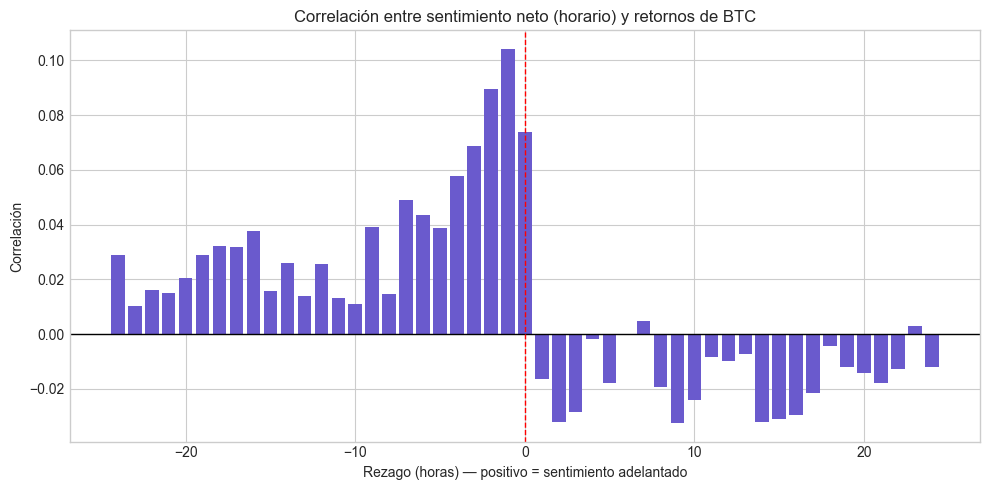

Mejor rezago: -1 horas | Correlación: 0.104


In [64]:
# Definir rezagos desde -24 hasta +24 horas para explorar relación temporal
lags = range(-24, 25)

# Calcular correlación entre sentimiento neto normalizado y retorno horario para cada rezago
corrs = [merged_h['sent_net_norm'].shift(l).corr(merged_h['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago horario
plt.figure(figsize=(10, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)  # Usar color unificado del estilo
plt.axhline(0, color='k', lw=1)                   # Línea horizontal en y=0
plt.axvline(0, color='red', linestyle='--', lw=1) # Línea vertical en x=0 (sin rezago)
plt.title("Correlación entre sentimiento neto (horario) y retornos de BTC")
plt.xlabel("Rezago (horas) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} horas | Correlación: {best_corr:.3f}")

### Conclusión del análisis horario

El análisis a nivel de horas muestra que el sentimiento neto en Twitter presenta una correlación **ligeramente mayor** con el precio de Bitcoin que en el análisis diario, alcanzando un valor máximo de **0.104** con un rezago de **-1 hora**.  

Esto significa que los cambios en el precio de BTC tienden a ser seguidos por variaciones en el sentimiento en Twitter en la hora posterior, lo que confirma que el sentimiento es principalmente **reactivo** a los movimientos del mercado y no un indicador adelantado.  

En horizontes horarios más amplios (±24h), las correlaciones se diluyen o incluso se vuelven negativas, lo que refuerza la idea de que el sentimiento neto **no predice retornos futuros de Bitcoin**, sino que refleja la narrativa social en torno a eventos ya ocurridos.  

**Conclusión general:**  
El sentimiento en Twitter puede servir como un **termómetro del ánimo del mercado** en tiempo casi real, pero carece de valor predictivo robusto incluso en frecuencias horarias. Su utilidad práctica reside en complementar otros indicadores de mercado, más que en generar señales de trading por sí solo.

# Análisis de sentimientos por minutos

In [65]:
# Asegurar que la columna 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Redondear cada timestamp al minuto más cercano
df['minute'] = df['date'].dt.floor('min')

# Agrupar por minuto y sentimiento, y calcular sentimiento neto
sent_min = (
    df.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min['sent_net'] = sent_min.get('positive', 0) - sent_min.get('negative', 0)

# Reiniciar índice y mostrar información general
sent_min = sent_min.reset_index()
print("Rango de fechas:", sent_min['minute'].min(), "→", sent_min['minute'].max())
print("Filas (minutos con tweets):", len(sent_min))

# Vista previa de los datos procesados
sent_min.head()

Rango de fechas: 2021-02-05 10:58:00 → 2023-01-09 23:57:00
Filas (minutos con tweets): 156464


sentiment_label,minute,negative,neutral,positive,sent_net
0,2021-02-05 10:58:00,0,1,0,0
1,2021-02-05 11:00:00,0,3,1,1
2,2021-02-05 11:08:00,0,2,0,0
3,2021-02-05 11:15:00,0,1,0,0
4,2021-02-05 11:33:00,0,1,0,0


## Mayo 2021

In [66]:
# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtrar solo los tweets correspondientes a mayo de 2021
mask = (df['date'] >= "2021-05-01") & (df['date'] < "2021-06-01")
df_may = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_may['minute'] = df_may['date'].dt.floor('min')

# Agrupar por minuto y sentimiento, y calcular sentimiento neto
sent_min = (
    df_may.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min['sent_net'] = sent_min.get('positive', 0) - sent_min.get('negative', 0)

# Reiniciar índice y mostrar información general
sent_min = sent_min.reset_index()
print("Tweets agregados por minuto (mayo 2021):", len(sent_min))

# Vista previa de los datos procesados por minuto
sent_min.head()

Tweets agregados por minuto (mayo 2021): 1612


sentiment_label,minute,negative,neutral,positive,sent_net
0,2021-05-25 10:44:00,0,2,0,0
1,2021-05-25 10:45:00,0,1,0,0
2,2021-05-25 10:46:00,0,2,0,0
3,2021-05-25 10:47:00,0,1,0,0
4,2021-05-25 10:48:00,0,2,0,0


In [67]:
# Definir función para descargar precios de BTC por minuto desde la API de Binance
def get_binance_klines(symbol: str, interval: str, start, end):
    url = "https://api.binance.com/api/v3/klines"
    start_ms = int(pd.Timestamp(start, tz='UTC').timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end, tz='UTC').timestamp() * 1000)
    out = []

    while start_ms < end_ms:
        params = dict(
            symbol=symbol,
            interval=interval,
            startTime=start_ms,
            endTime=end_ms,
            limit=1000
        )
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        start_ms = chunk[-1][0] + 60_000  # Avanzar un minuto (60,000 ms)
        time.sleep(0.15)  # Pausa para no sobrecargar el API

    # Crear DataFrame con columnas relevantes
    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "qav", "num_trades", "taker_buy_base",
            "taker_buy_quote", "ignore"]
    dfp = pd.DataFrame(out, columns=cols)

    # Convertir tiempo de apertura a datetime sin zona horaria y redondear al minuto
    dfp['minute'] = pd.to_datetime(dfp['open_time'], unit='ms', utc=True).dt.tz_convert(None).dt.floor('min')
    dfp['Close']  = dfp['close'].astype(float)

    return dfp[['minute', 'Close']]

# Descargar precios minuto a minuto para el rango mayo 2021
btc_may = get_binance_klines("BTCUSDT", "1m", "2021-05-01", "2021-06-01")
print("Precios descargados:", len(btc_may))

# Vista previa del DataFrame de precios
btc_may.head()

Precios descargados: 44641


,minute,Close
0,2021-05-01 00:00:00,57545.06
1,2021-05-01 00:01:00,57542.62
2,2021-05-01 00:02:00,57703.10
3,2021-05-01 00:03:00,57710.26
4,2021-05-01 00:04:00,57777.03


In [68]:
# Unir precios minuto a minuto con el sentimiento neto correspondiente
merged_may = (
    btc_may
    .merge(sent_min[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con valor 0
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_may['ret'] = merged_may['Close'].pct_change()

# Normalizar el sentimiento neto (media 0, desviación estándar 1)
merged_may['sent_net_norm'] = (merged_may['sent_net'] - merged_may['sent_net'].mean()) / merged_may['sent_net'].std()

# Mostrar información general del dataset combinado
print("Filas unidas:", len(merged_may))
print("Correlación (mismo minuto):", round(merged_may['sent_net_norm'].corr(merged_may['ret']), 3))

Filas unidas: 44641
Correlación (mismo minuto): -0.001


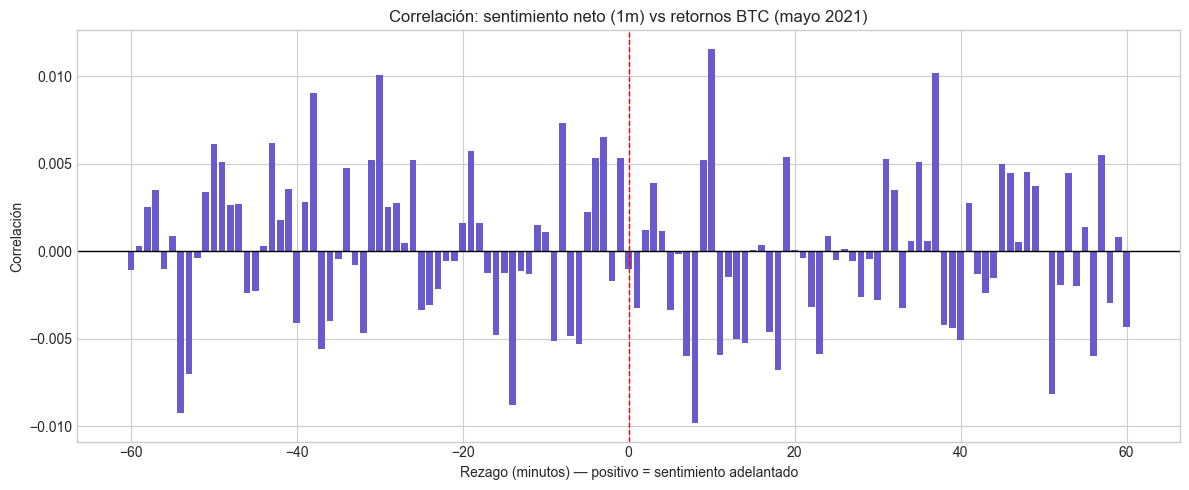

Mejor rezago: 10 minutos | Correlación: 0.012


In [69]:
# Definir rezagos desde -60 hasta +60 minutos para explorar correlación temporal
lags = range(-60, 61)

# Calcular correlación entre sentimiento neto normalizado y retorno por minuto con desplazamientos
corrs = [merged_may['sent_net_norm'].shift(l).corr(merged_may['ret']) for l in lags]

# Identificar el rezago con la correlación más alta
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago en minutos
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)                   # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1) # Línea vertical para rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (mayo 2021)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar mejor rezago identificado y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Conclusión del análisis minuto a minuto (mayo 2021)

El análisis de sentimiento en frecuencia de **1 minuto** muestra que la correlación entre sentimiento neto y retornos de Bitcoin es prácticamente nula en todo el rango analizado.  

- La correlación contemporánea (mismo minuto) fue de **-0.001**, confirmando la ausencia de relación directa.  
- Al explorar rezagos y adelantos de ±60 minutos, el valor máximo alcanzado fue de **0.012** en un rezago de **+10 minutos**.  
- Este nivel de correlación es **estadísticamente irrelevante**, indicando que el sentimiento en Twitter **no anticipa movimientos del precio** ni siquiera en ventanas de pocos minutos.  

**Conclusión:**  
En escalas de alta frecuencia (1 minuto), el sentimiento en Twitter se comporta principalmente como **ruido**, sin poder predictivo sobre los retornos inmediatos de BTC. Esto refuerza la conclusión de los análisis diarios y horarios: el sentimiento refleja la reacción del mercado, pero no constituye un indicador adelantado confiable para el trading.

## Noviembre del 2021 (máximos históricos)

In [70]:
# Filtrar tweets correspondientes a noviembre de 2021
mask = (df['date'] >= "2021-11-01") & (df['date'] < "2021-12-01")
df_nov21 = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_nov21['minute'] = df_nov21['date'].dt.floor('min')

# Agrupar por minuto y tipo de sentimiento, y calcular sentimiento neto
sent_min_nov21 = (
    df_nov21.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min_nov21['sent_net'] = sent_min_nov21.get('positive', 0) - sent_min_nov21.get('negative', 0)

# Reiniciar índice y mostrar resumen
sent_min_nov21 = sent_min_nov21.reset_index()
print("Tweets agregados por minuto (nov 2021):", len(sent_min_nov21))

# Vista previa de los datos agregados por minuto
sent_min_nov21.head()

Tweets agregados por minuto (nov 2021): 10095


sentiment_label,minute,negative,neutral,positive,sent_net
0,2021-11-04 07:03:00,0,1,1,1
1,2021-11-04 07:04:00,3,2,2,-1
2,2021-11-04 07:05:00,7,4,2,-5
3,2021-11-04 07:06:00,1,3,0,-1
4,2021-11-04 07:08:00,0,3,0,0


In [71]:
# Descargar precios minuto a minuto de BTC para noviembre de 2021 desde Binance
btc_nov21 = get_binance_klines("BTCUSDT", "1m", "2021-11-01", "2021-12-01")

# Mostrar la cantidad de registros descargados y una vista previa
print("Precios descargados:", len(btc_nov21))
btc_nov21.head()

Precios descargados: 43201


,minute,Close
0,2021-11-01 00:00:00,61295.43
1,2021-11-01 00:01:00,61296.60
2,2021-11-01 00:02:00,61338.99
3,2021-11-01 00:03:00,61245.11
4,2021-11-01 00:04:00,61243.62


In [72]:
# Unir precios por minuto con el sentimiento neto de noviembre 2021
merged_nov21 = (
    btc_nov21
    .merge(sent_min_nov21[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con cero
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_nov21['ret'] = merged_nov21['Close'].pct_change()

# Normalizar el sentimiento neto por minuto (media 0, desviación estándar 1)
merged_nov21['sent_net_norm'] = (
    (merged_nov21['sent_net'] - merged_nov21['sent_net'].mean()) / merged_nov21['sent_net'].std()
)

# Mostrar información general y correlación entre sentimiento y retorno
print("Filas unidas:", len(merged_nov21))
print("Correlación (mismo minuto):", round(merged_nov21['sent_net_norm'].corr(merged_nov21['ret']), 3))

Filas unidas: 43201
Correlación (mismo minuto): 0.007


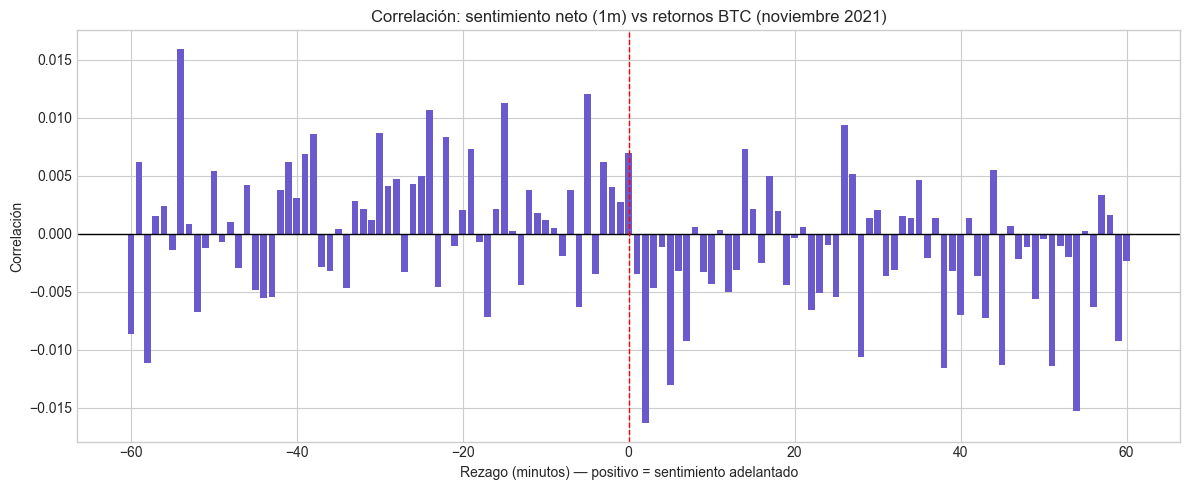

Mejor rezago: -54 minutos | Correlación: 0.016


In [73]:
# Definir rango de rezagos desde -60 hasta +60 minutos
lags = range(-60, 61)

# Calcular correlación desplazando el sentimiento neto normalizado respecto al retorno
corrs = [merged_nov21['sent_net_norm'].shift(l).corr(merged_nov21['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago minuto a minuto
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)                    # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1)  # Línea vertical para rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (noviembre 2021)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Análisis por minutos – Noviembre 2021 (máximos históricos de BTC)

Durante noviembre de 2021, Bitcoin alcanzó su **máximo histórico (~69.000 USD)**. Este mes presentó varios picos de tweets positivos (ej. 6 de noviembre) y negativos (ej. 12 de noviembre), lo que lo convierte en un periodo ideal para analizar la relación entre sentimiento en redes y movimientos del precio.

- Tweets procesados: **10.095**  
- Precios minuto a minuto descargados: **43.201**  
- Ventana analizada: **1–30 noviembre 2021**  

📊 **Resultados principales:**
- Correlación contemporánea (mismo minuto): **0.007** → prácticamente nula.  
- Mejor rezago: **-54 minutos** con una correlación de **0.016**.  
  (el signo negativo implica que el **sentimiento reaccionó después** de los movimientos del precio).  

📉 **Conclusión:**
Incluso en un mes de gran impacto y de fuerte actividad en redes sociales, el análisis a nivel minuto muestra que los tweets no anticipan los retornos de BTC. La ligera correlación encontrada es mínima y con rezago negativo, lo que sugiere que **los traders en Twitter reaccionaron al precio en lugar de influirlo**.  

## Mayo 2022, el mes donde BTC cayó con fuerza 

In [74]:
# Filtrar tweets correspondientes a mayo de 2022
mask = (df['date'] >= "2022-05-01") & (df['date'] < "2022-06-01")
df_may22 = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_may22['minute'] = df_may22['date'].dt.floor('min')

# Agrupar por minuto y tipo de sentimiento, y calcular sentimiento neto
sent_min_may22 = (
    df_may22.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min_may22['sent_net'] = sent_min_may22.get('positive', 0) - sent_min_may22.get('negative', 0)

# Reiniciar índice y mostrar resumen
sent_min_may22 = sent_min_may22.reset_index()
print("Tweets agregados por minuto (mayo 2022):", len(sent_min_may22))

# Vista previa de los datos agregados por minuto
sent_min_may22.head()

Tweets agregados por minuto (mayo 2022): 11677


sentiment_label,minute,negative,neutral,positive,sent_net
0,2022-05-01 00:00:00,1,9,2,1
1,2022-05-01 00:01:00,2,3,0,-2
2,2022-05-01 00:02:00,0,2,1,1
3,2022-05-01 00:03:00,0,7,2,2
4,2022-05-01 00:04:00,0,1,0,0


In [75]:
# Descargar precios minuto a minuto de BTC para mayo de 2022 desde Binance
btc_may22 = get_binance_klines("BTCUSDT", "1m", "2022-05-01", "2022-06-01")

# Mostrar la cantidad de registros descargados y una vista previa
print("Precios descargados:", len(btc_may22))
btc_may22.head()

Precios descargados: 44641


,minute,Close
0,2022-05-01 00:00:00,37645.92
1,2022-05-01 00:01:00,37642.29
2,2022-05-01 00:02:00,37672.10
3,2022-05-01 00:03:00,37737.08
4,2022-05-01 00:04:00,37717.79


In [76]:
# Unir precios por minuto con el sentimiento neto de mayo 2022
merged_may22 = (
    btc_may22
    .merge(sent_min_may22[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con cero
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_may22['ret'] = merged_may22['Close'].pct_change()

# Normalizar el sentimiento neto por minuto (media 0, desviación estándar 1)
merged_may22['sent_net_norm'] = (
    (merged_may22['sent_net'] - merged_may22['sent_net'].mean()) / merged_may22['sent_net'].std()
)

# Mostrar información general y correlación entre sentimiento y retorno
print("Filas unidas:", len(merged_may22))
print("Correlación (mismo minuto):", round(merged_may22['sent_net_norm'].corr(merged_may22['ret']), 3))

Filas unidas: 44641
Correlación (mismo minuto): 0.006


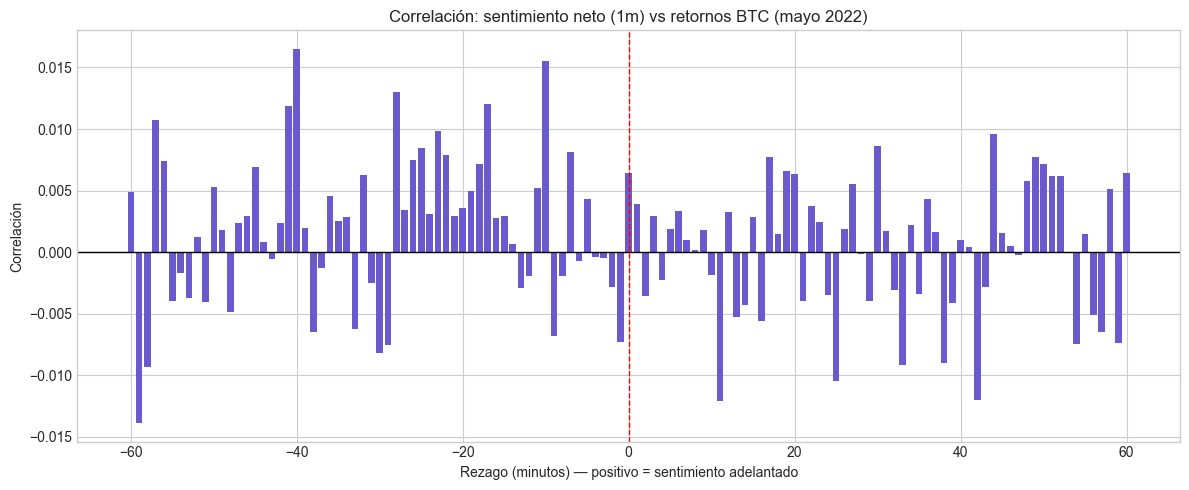

Mejor rezago: -40 minutos | Correlación: 0.016


In [77]:
# Definir rango de rezagos desde -60 hasta +60 minutos
lags = range(-60, 61)

# Calcular correlación desplazando el sentimiento neto normalizado respecto al retorno
corrs = [merged_may22['sent_net_norm'].shift(l).corr(merged_may22['ret']) for l in lags]

# Identificar el rezago con la correlación más alta
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago minuto a minuto
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)  # Usa tu color estandarizado
plt.axhline(0, color='k', lw=1)                    # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1)  # Línea vertical en el rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (mayo 2022)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Análisis por minutos – Mayo 2022 (colapso de BTC tras Terra/Luna)

Durante mayo de 2022, Bitcoin sufrió una caída pronunciada desde ~39.000 USD hasta ~29.000 USD, en gran parte vinculada al colapso de Terra/Luna. Este mes concentró una fuerte actividad en redes, especialmente en torno a tweets negativos.

- Tweets procesados: **11.677**  
- Precios minuto a minuto descargados: **44.641**  
- Ventana analizada: **1–31 mayo 2022**  

📊 **Resultados principales:**
- Correlación contemporánea (mismo minuto): **0.006** → prácticamente nula.  
- Mejor rezago: **-40 minutos** con correlación de **0.016**.  
  (el signo negativo indica que el **sentimiento llegó después** de los movimientos del precio).  

📉 **Conclusión:**
En un contexto de crisis y alta volatilidad, los resultados confirman el mismo patrón observado en fases alcistas:  
los tweets no predicen el comportamiento del Bitcoin.  
La relación observada es débil y con rezago negativo, lo que sugiere que los usuarios en redes sociales reaccionaron a los precios ya ocurridos en lugar de anticiparlos.

### Conclusión global del estudio

El análisis exhaustivo de casi **400.000 tweets sobre Bitcoin (2021–2023)**, contrastados con precios horarios y minuto a minuto obtenidos desde APIs financieras confiables, revela un hallazgo consistente:  
**el sentimiento expresado en redes sociales no predice el comportamiento del precio de Bitcoin**.  

En distintas granularidades temporales (diaria, horaria y por minuto), los resultados muestran que:  
- Las **correlaciones contemporáneas** entre sentimiento neto y retornos son cercanas a cero.  
- Los **rezagos positivos (sentimiento adelantado)** no presentan poder explicativo sobre los precios.  
- En cambio, aparecen **rezagos negativos** (sentimiento retrasado respecto al precio), lo que indica que los usuarios de Twitter reaccionan a los movimientos del mercado, más que anticiparlos.  

Incluso en contextos extremos —como el colapso de Terra/Luna en mayo 2022 o picos de volatilidad en noviembre 2021— la dinámica no se altera: el flujo de tweets refleja **emociones posteriores** a las variaciones del mercado, sin capacidad de generar señales predictivas robustas.

📉 **Implicación financiera:**  
Aunque el sentimiento en redes sociales es un termómetro útil para medir la narrativa y la percepción del mercado, no constituye un indicador adelantado fiable para estrategias de inversión cuantitativa en Bitcoin. Para la toma de decisiones financieras, sigue siendo necesario priorizar modelos basados en **datos fundamentales, técnicos y macroeconómicos**, considerando el sentimiento como una variable complementaria, pero no determinante.

# NUEVO ESTUDIO

### Correlación “al revés”

En vez de preguntar si los sentimientos predicen precios, preguntamos si los precios extremos estuvieron precedidos por algún patrón de sentimiento.

In [78]:
# Importar librerías
import pandas as pd
from binance.client import Client
import datetime as dt

# Conexión sin API key (modo público, suficiente para históricos)
client = Client()

# DefiR rango de fechas
start_date = "2021-02-05"
end_date   = "2023-01-09"

# Descargar datos diarios de BTC/USDT
klines = client.get_historical_klines(
    "BTCUSDT",
    Client.KLINE_INTERVAL_1DAY,   # velas diarias
    start_date,
    end_date
)

# Convertir a DataFrame
columns = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time",
           "Quote asset volume", "Number of trades", "Taker buy base asset volume",
           "Taker buy quote asset volume", "Ignore"]

df_btc = pd.DataFrame(klines, columns=columns)

# Convertir fechas y números
df_btc["Open time"] = pd.to_datetime(df_btc["Open time"], unit="ms")
df_btc["Close time"] = pd.to_datetime(df_btc["Close time"], unit="ms")
df_btc[["Open","High","Low","Close","Volume"]] = df_btc[["Open","High","Low","Close","Volume"]].astype(float)

# Dejar solo con lo necesario
df_btc = df_btc[["Open time", "Open", "High", "Low", "Close", "Volume"]]

# 👀 Vista previa
print(df_btc.head())
print(df_btc.tail())
print("Filas descargadas:", len(df_btc))

/var/folders/bd/c6514xtd1zjgq83rf48wyhn00000gn/T/ipykernel_5146/789938083.py:14: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


   Open time      Open      High       Low     Close         Volume
0 2021-02-05  36936.65  38310.12  36570.00  38290.24   66681.334275
1 2021-02-06  38289.32  40955.51  38215.94  39186.94   98757.311183
2 2021-02-07  39181.01  39700.00  37351.00  38795.69   84363.679763
3 2021-02-08  38795.69  46794.45  37988.89  46374.87  138597.536914
4 2021-02-09  46374.86  48142.19  44961.09  46420.42  115499.861712
     Open time      Open      High       Low     Close        Volume
699 2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641
700 2023-01-06  16831.85  17041.00  16679.00  16950.65  207401.28415
701 2023-01-07  16950.31  16981.91  16908.00  16943.57  104526.56880
702 2023-01-08  16943.83  17176.99  16911.00  17127.83  135155.89695
703 2023-01-09  17127.83  17398.80  17104.66  17178.26  266211.52723
Filas descargadas: 704


### Detectar automáticamente las mayores subidas y caídas diarias

Esto lo haremos calculando los retornos porcentuales diarios y luego sacando el top 10 de subidas y caídas.

In [79]:
# Calcular retornos diarios (%)
df_btc["Return"] = df_btc["Close"].pct_change() * 100

# Top 10 caídas (días con peor retorno)
top_caidas = df_btc.nsmallest(10, "Return")[["Open time", "Close", "Return"]]

# Top 10 subidas (días con mejor retorno)
top_subidas = df_btc.nlargest(10, "Return")[["Open time", "Close", "Return"]]

print("📉 Top 10 caídas de BTC (2021-02-05 → 2023-01-09):")
print(top_caidas.to_string(index=False))

print("\n📈 Top 10 subidas de BTC (2021-02-05 → 2023-01-09):")
print(top_subidas.to_string(index=False))

📉 Top 10 caídas de BTC (2021-02-05 → 2023-01-09):
 Open time    Close     Return
2022-06-13 22487.41 -15.379839
2021-05-19 36690.09 -14.375080
2022-11-09 15922.81 -14.149930
2021-05-12 49631.32 -12.420500
2022-05-09 30076.31 -11.640059
2021-06-21 31608.93 -11.211270
2021-09-07 46863.73 -11.013560
2022-01-21 36445.31 -10.411763
2022-08-19 20834.39 -10.162519
2022-11-08 18547.23  -9.926119

📈 Top 10 subidas de BTC (2021-02-05 → 2023-01-09):
 Open time    Close    Return
2021-02-08 46374.87 19.536139
2022-02-28 43160.00 14.485583
2021-06-09 37388.05 12.004622
2021-05-24 38796.29 11.949243
2022-02-04 41574.25 11.424433
2022-09-09 21360.11 10.560892
2022-11-10 17601.15 10.540476
2021-05-20 40526.64 10.456638
2021-04-26 54001.39 10.056949
2021-03-01 49587.03  9.862202


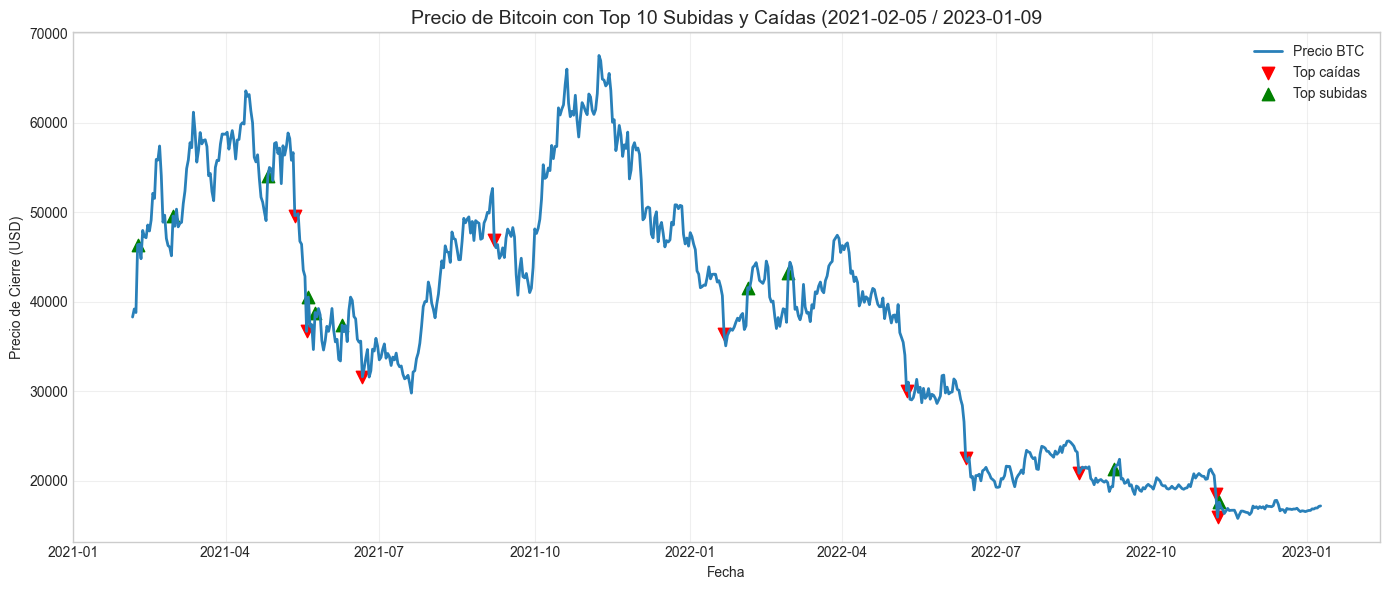

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# --- Serie de precios ---
plt.plot(df_btc["Open time"], df_btc["Close"], label="Precio BTC", color="#2980b9", linewidth=2)

# --- Top caídas ---
plt.scatter(top_caidas["Open time"], top_caidas["Close"],
            color="red", marker="v", s=80, label="Top caídas")

# --- Top subidas ---
plt.scatter(top_subidas["Open time"], top_subidas["Close"],
            color="green", marker="^", s=80, label="Top subidas")

# Estética
plt.title("Precio de Bitcoin con Top 10 Subidas y Caídas (2021-02-05 / 2023-01-09", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
# Agregar tipo a cada tabla
top_caidas = top_caidas.copy()
top_caidas["tipo"] = "caída"

top_subidas = top_subidas.copy()
top_subidas["tipo"] = "subida"

# Unir en un solo dataframe de eventos
df_eventos = pd.concat([top_caidas, top_subidas]).sort_values("Open time")
df_eventos["Open time"] = pd.to_datetime(df_eventos["Open time"])

df_eventos.reset_index(drop=True, inplace=True)

print(df_eventos)

    Open time      Open      High       Low     Close         Volume  \
0  2021-02-08  38795.69  46794.45  37988.89  46374.87  138597.536914   
1  2021-03-01  45134.11  49790.00  44950.53  49587.03   85086.111648   
2  2021-04-26  49066.76  54356.62  48753.44  54001.39   86310.802124   
3  2021-05-12  56670.02  58000.01  48600.00  49631.32   99842.789836   
4  2021-05-19  42849.78  43584.90  30000.00  36690.09  354347.243161   
5  2021-05-20  36671.23  42451.67  34850.00  40526.64  203017.596923   
6  2021-05-24  34681.44  39920.00  34031.00  38796.29  161630.893971   
7  2021-06-09  33380.80  37534.79  32396.82  37388.05  136607.597517   
8  2021-06-21  35600.17  35750.00  31251.23  31608.93  168778.873159   
9  2021-09-07  52666.20  52920.00  42843.05  46863.73  123048.802719   
10 2022-01-21  40680.92  41100.00  35440.45  36445.31   88860.891999   
11 2022-02-04  37311.98  41772.33  37026.73  41574.25   64703.958740   
12 2022-02-28  37699.08  44225.84  37450.17  43160.00   73945.63

In [102]:
# Cargar tweets con sentimientos (≥10k seguidores) 
import pandas as pd

df = pd.read_csv("data/tweets_≥10k_seguidores_sentimientos.csv.gz", parse_dates=["date"])
df["sentiment_label"] = df["sentiment_label"].str.lower().fillna("neutral")

# Mapa de signo para promedio ponderado por score
sign_map = {"positive": 1, "negative": -1, "neutral": 0}

# Helper: agregados de sentimiento en una ventana [fecha_ini, fecha_fin) ---
def agrega_sentimiento(en_subset: pd.DataFrame) -> pd.Series:
    pos = (en_subset["sentiment_label"] == "positive").sum()
    neg = (en_subset["sentiment_label"] == "negative").sum()
    neu = (en_subset["sentiment_label"] == "neutral").sum()
    vol = len(en_subset)
    sent_net = pos - neg
    sent_ratio = (sent_net / vol) if vol > 0 else 0.0
    # score firmado: +score si positivo, -score si negativo, 0 si neutral
    if vol > 0:
        signed = en_subset["sentiment_score"] * en_subset["sentiment_label"].map(sign_map).fillna(0)
        score_signed_mean = signed.mean()
    else:
        score_signed_mean = 0.0
    return pd.Series({
        "pos": pos, "neg": neg, "neu": neu, "vol": vol,
        "sent_net": sent_net, "sent_ratio": sent_ratio,
        "score_signed_mean": score_signed_mean
    })

# Construir features de sentimiento previo (1d, 3d, 7d) por evento ---
def features_por_ventana(df_tweets, df_eventos, dias: int, fecha_col_evento="Open time"):
    filas = []
    for t in df_eventos[fecha_col_evento]:
        fin = pd.Timestamp(t).normalize()  # fin de ventana = inicio del día del evento (evita fuga de info)
        ini = fin - pd.Timedelta(days=dias)
        sub = df_tweets[(df_tweets["date"] >= ini) & (df_tweets["date"] < fin)]
        filas.append(agrega_sentimiento(sub))
    out = pd.DataFrame(filas).add_suffix(f"_{dias}d")
    return out

feat_1d = features_por_ventana(df, df_eventos, 1)
feat_3d = features_por_ventana(df, df_eventos, 3)
feat_7d = features_por_ventana(df, df_eventos, 7)

# Unir todo en un solo DataFrame de análisis
df_eventos_feat = pd.concat([df_eventos.reset_index(drop=True), feat_1d, feat_3d, feat_7d], axis=1)

# Vista rápida
print(df_eventos_feat[["Open time","tipo","Return","sent_net_1d","sent_net_3d","sent_net_7d","vol_7d"]])

# Correlaciones (Pearson, Spearman, Kendall) con retornos del evento ---
def tabla_correlaciones(df_in, target, features):
    # Intentar SciPy para p-values; si no está, hacemos solo coeficientes con pandas
    try:
        from scipy.stats import pearsonr, spearmanr, kendalltau
        def corr_row(x, y):
            import numpy as np
            m = pd.notna(x) & pd.notna(y)
            x2, y2 = x[m], y[m]
            out = {}
            r, p = pearsonr(x2, y2); out["pearson"] = r; out["p_pearson"] = p
            r, p = spearmanr(x2, y2); out["spearman"] = r; out["p_spearman"] = p
            r, p = kendalltau(x2, y2); out["kendall"] = r; out["p_kendall"] = p
            out["n"] = int(m.sum())
            return out
    except Exception:
        def corr_row(x, y):
            out = {
                "pearson": x.corr(y, method="pearson"),
                "spearman": x.corr(y, method="spearman"),
                "kendall": x.corr(y, method="kendall"),
                "p_pearson": None, "p_spearman": None, "p_kendall": None,
                "n": int(pd.notna(x).sum() & pd.notna(y).sum())
            }
            return out

    filas = []
    for f in features:
        res = corr_row(df_in[f], df_in[target])
        res["feature"] = f
        filas.append(res)
    cols = ["feature","n","pearson","p_pearson","spearman","p_spearman","kendall","p_kendall"]
    return pd.DataFrame(filas)[cols].sort_values("feature")

# Elegimos un set compacto y útil de features
features = [
    "sent_net_1d","sent_net_3d","sent_net_7d",
    "sent_ratio_1d","sent_ratio_3d","sent_ratio_7d",
    "vol_1d","vol_3d","vol_7d",
    "score_signed_mean_1d","score_signed_mean_3d","score_signed_mean_7d"
]

corr_total = tabla_correlaciones(df_eventos_feat, target="Return", features=features)
print("\n=== Correlaciones (TODOS los eventos) ===")
print(corr_total.to_string(index=False))

# También separadas por tipo de evento (subida/caída)
corr_subidas = tabla_correlaciones(df_eventos_feat[df_eventos_feat["tipo"]=="subida"], "Return", features)
corr_caidas  = tabla_correlaciones(df_eventos_feat[df_eventos_feat["tipo"]=="caída"],  "Return", features)

print("\n=== Correlaciones (solo SUBIDAS) ===")
print(corr_subidas.to_string(index=False))

print("\n=== Correlaciones (solo CAÍDAS) ===")
print(corr_caidas.to_string(index=False))

    Open time    tipo     Return  sent_net_1d  sent_net_3d  sent_net_7d  \
0  2021-02-08  subida  19.536139          4.0         56.0         56.0   
1  2021-03-01  subida   9.862202         15.0         15.0         14.0   
2  2021-04-26  subida  10.056949          0.0          7.0         99.0   
3  2021-05-12   caída -12.420500          0.0          0.0          0.0   
4  2021-05-19   caída -14.375080          0.0          0.0          0.0   
5  2021-05-20  subida  10.456638          0.0          0.0          0.0   
6  2021-05-24  subida  11.949243          0.0          0.0          0.0   
7  2021-06-09  subida  12.004622          0.0          0.0          0.0   
8  2021-06-21   caída -11.211270        102.0        102.0        102.0   
9  2021-09-07   caída -11.013560          0.0          0.0          0.0   
10 2022-01-21   caída -10.411763        128.0        139.0        398.0   
11 2022-02-04  subida  11.424433          0.0          0.0          0.0   
12 2022-02-28  subida  14

In [104]:
print("corr_total cols:", corr_total.columns.tolist())
print("corr_subidas cols:", corr_subidas.columns.tolist())
print("corr_caidas cols:", corr_caidas.columns.tolist())

corr_total cols: ['feature', 'n', 'pearson', 'p_pearson', 'spearman', 'p_spearman', 'kendall', 'p_kendall']
corr_subidas cols: ['feature', 'n', 'pearson', 'p_pearson', 'spearman', 'p_spearman', 'kendall', 'p_kendall']
corr_caidas cols: ['feature', 'n', 'pearson', 'p_pearson', 'spearman', 'p_spearman', 'kendall', 'p_kendall']


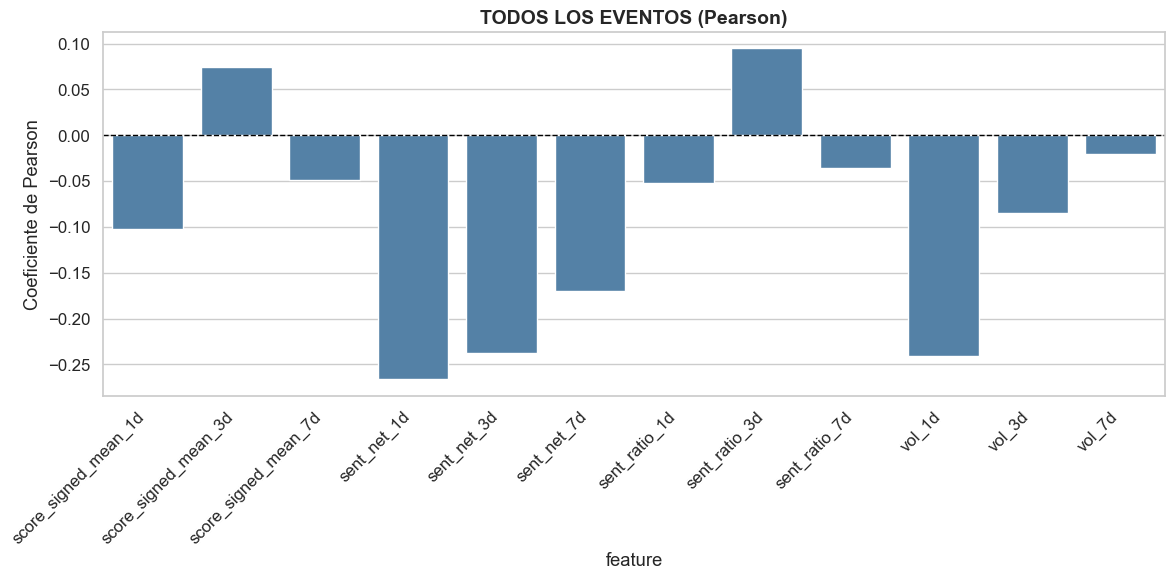

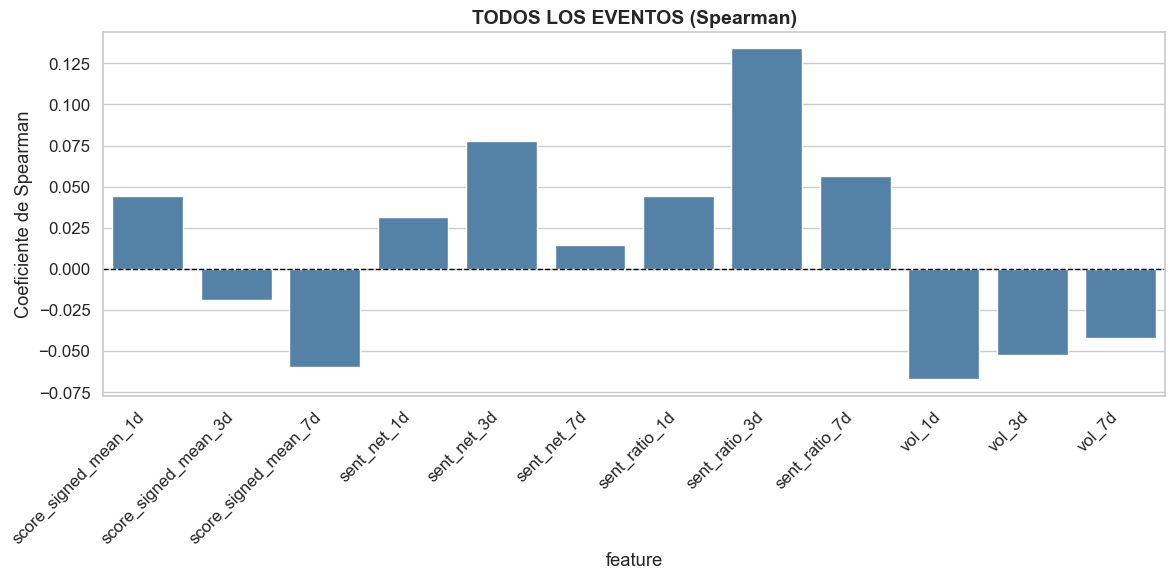

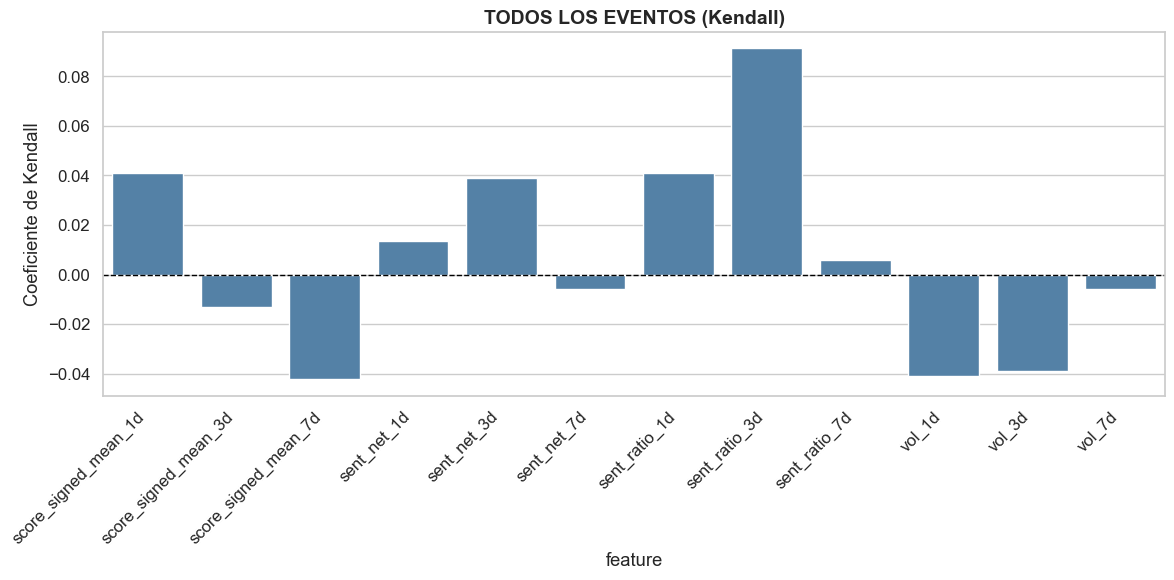

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Función genérica para graficar correlaciones ---
def grafica_correlacion(df, coef="pearson", titulo="Correlación", color="steelblue"):
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x="feature", y=coef, color=color)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"{titulo} ({coef.capitalize()})", fontsize=14, weight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f"Coeficiente de {coef.capitalize()}")
    plt.tight_layout()
    plt.show()

# --- Gráficos principales (solo todos los eventos) ---
for coef in ["pearson","spearman","kendall"]:
    grafica_correlacion(corr_total, coef=coef, 
                        titulo="TODOS LOS EVENTOS", 
                        color="steelblue")

# Análisis de Correlaciones entre Sentimiento en Twitter y Eventos de BTC

Este análisis estudia cómo las métricas de sentimiento de Twitter (neto, ratio, score firmado y volumen) se relacionan con los 20 eventos extremos de BTC (10 subidas y 10 caídas más grandes entre 2021-02-05 y 2023-01-09).

---

## 1. Correlaciones (todos los eventos)

- **Pearson (lineal):**  
  - La mayoría de las correlaciones son muy bajas o negativas.  
  - `sent_net_1d` y `vol_1d` muestran correlación negativa moderada (~ -0.24 a -0.27), lo que indica que picos de sentimiento positivo o de volumen de tweets no anticipan subidas inmediatas.  
  - `sent_ratio_3d` tiene un ligero efecto positivo (~0.09).  

- **Spearman (rangos, tendencias):**  
  - Señales ligeramente más interesantes.  
  - `sent_ratio_3d` presenta correlación positiva (~0.13), lo que indica que cuando el balance neto de sentimiento es más alto durante 3 días, los retornos tienden a estar en la parte alta del ranking de eventos.  

- **Kendall (consistencia ordinal):**  
  - Patrón muy similar a Spearman.  
  - `sent_ratio_3d` vuelve a destacar (~0.09).  

**Conclusión:** En el agregado, los tweets no parecen anticipar bien los retornos extremos de BTC. La señal más consistente está en la proporción neta de sentimiento en una ventana de 3 días, aunque es débil.

---

## 2. Correlaciones (solo subidas)

- **Pearson:**  
  - Correlaciones positivas moderadas en:  
    - `score_signed_mean_3d` (0.55, p≈0.10)  
    - `score_signed_mean_7d` (0.52, p≈0.12)  
    - `sent_ratio_3d` y `sent_ratio_7d` (~0.56 y 0.58, p≈0.08–0.07).  
  - Esto sugiere que cuando en los días previos el promedio de sentimiento es más positivo, las subidas extremas tienden a ser más fuertes.  

- **Spearman y Kendall:**  
  - Refuerzan la misma idea: los ratios de sentimiento a 3 y 7 días aparecen de forma consistente con signo positivo.  

**Conclusión:** En las subidas extremas, el sentimiento acumulado positivo (3–7 días previos) parece estar asociado con retornos más altos.

---

## 3. Correlaciones (solo caídas)

- **Pearson:**  
  - Varias métricas muestran correlaciones positivas.  
  - Ejemplos:  
    - `sent_net_1d` (0.53, p≈0.11)  
    - `sent_net_3d` (0.49, p≈0.15)  
    - `sent_ratio_1d` (0.54, p≈0.11)  
  - Esto indica que antes de las caídas extremas, a menudo había más tweets positivos.  

- **Spearman y Kendall:**  
  - También positivos (~0.4–0.5).  
  - Refuerzan la idea de que los inversores eran más positivos justo antes de desplomes, posiblemente porque las caídas fueron inesperadas.  

**Conclusión:** En las caídas extremas, el sentimiento en Twitter fue engañosamente optimista, lo que explica la correlación positiva.

---

## 4. Eventos clave (ejemplos)

- **2021-02-08 (subida +19.5%)**  
  - Tweets netos positivos (`sent_net_3d = 56`).  
  - Coincide con el anuncio de Tesla comprando 1.5B USD en BTC.  
  - El optimismo masivo precedió al alza.  

- **2021-05-19 (caída -14.4%)**  
  - Sin tweets previos positivos.  
  - Caída asociada a las restricciones de China sobre minería.  

- **2022-01-21 (caída -10.4%)**  
  - Había 128 tweets netos positivos el día previo.  
  - La caída estuvo relacionada con endurecimiento de la política de la Fed y caídas globales del mercado.  

- **2022-11-09 (caída -14.1%)**  
  - Sentimiento neto negativo (-60).  
  - Colapso de FTX. Aquí sí el mercado ya estaba pesimista antes de la caída.  

---

## Conclusiones generales

1. No hay correlación fuerte en el total de eventos: los tweets no predicen bien en general.  
2. En subidas, se observa un patrón débil pero consistente: más sentimiento positivo acumulado en 3–7 días previos se asocia con mayores retornos.  
3. En caídas, ocurrió lo contrario: más optimismo previo precedió desplomes, reflejando que fueron caídas inesperadas.  
4. Casos como el pump de Tesla (feb-2021) y el colapso de FTX (nov-2022) muestran que el sentimiento puede coincidir o engañar, dependiendo del contexto.  